- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

In [2]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [4]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n")

CONFIGURE THE BIGQUERY SETTINGS

In [5]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [6]:
query = """
SELECT 
a.*,
b.average_wage
FROM `ironhacks-data.ironhacks_competition.unemployment_data`a

JOIN `ironhacks-data.ironhacks_competition.wage_data` b 
ON a.uu_id = b.uu_id


"""

In [7]:
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
#data['timeperiod']= pd.to_datetime(data['timeperiod'])
data.head()

uu_id  timeperiod  week_number  countyfips  \
0  f013068de98db1470bd986137a0c6d23    20220416           16       18003   
1  21957d5517323845818d87623589e1ba    20220319           12       18089   
2  6a5609f385912113b6f1014b958ed748    20220326           13       18089   
3  46b2882ec4c373527ec33f7bd4f1388d    20220716           29       18089   
4  37495d17e82f7df326bfc2c4c090f7b7    20220409           15       18089   

   tract                              tract_name  total_claims  \
0    900   Census Tract 9, Allen County, Indiana            22   
1  10400  Census Tract 104, Lake County, Indiana           111   
2  11500  Census Tract 115, Lake County, Indiana            39   
3  20700  Census Tract 207, Lake County, Indiana            14   
4  21900  Census Tract 219, Lake County, Indiana           155   

   edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  ...  gender_male  \
0                0             <NA>                 14  ...         <NA>   
1                0             <NA>                108  ...           35   
2                0             <NA>               <NA>  ...         <NA>   
3                0             <NA>               <NA>  ...         <NA>   
4                0             <NA>                 69  ...           65   

   gender_na race_amerindian race_asian race_black  race_noanswer  \
0          0               0          0         11              0   
1          0               0          0       <NA>           <NA>   
2          0               0          0         39              0   
3          0               0       <NA>         10              0   
4          0               0          0        135           <NA>   

   race_hawaiiannative  race_other  race_white  average_wage  
0                    0        <NA>        <NA>   8347.125000  
1                    0           0           0   7036.636364  
2                    0           0           0   7890.142857  
3                    0        <NA>        <NA>   7534.375000  
4                 <NA>        <NA>        <NA>  11825.125000  

[5 rows x 26 columns]

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
get_ipython().system('pip install db-dtypes')

In [10]:
data = data.fillna(0)

In [11]:
data = data.fillna(0)

In [12]:
data.describe()

timeperiod  week_number    countyfips          tract  \
count          13977.0      13977.0       13977.0        13977.0   
mean   20220478.413322    18.699936  18088.968377  211210.451885   
std         252.868196    11.006898     40.990629  287447.640427   
min         20220101.0          1.0       18001.0          100.0   
25%         20220226.0          9.0       18063.0        10100.0   
50%         20220430.0         18.0       18095.0        42901.0   
75%         20220716.0         29.0       18099.0       342600.0   
max         20220910.0         37.0       18183.0       976400.0   

       total_claims  edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  \
count       13977.0          13977.0          13977.0            13977.0   
mean      23.049796         0.036131         0.454246           7.025041   
std        14.68286         0.905556           3.2236          12.074039   
min            10.0              0.0              0.0                0.0   
25%            14.0              0.0              0.0                0.0   
50%            19.0              0.0              0.0                0.0   
75%            27.0              0.0              0.0               12.0   
max           170.0             41.0             78.0              137.0   

       edu_post_hs  edu_unknown  ...  gender_male  gender_na  race_amerindian  \
count      13977.0      13977.0  ...      13977.0    13977.0          13977.0   
mean       3.25542      0.10181  ...     4.606854   0.006296         0.010088   
std       8.260031     1.569013  ...     10.20408   0.483962         0.466507   
min            0.0          0.0  ...          0.0        0.0              0.0   
25%            0.0          0.0  ...          0.0        0.0              0.0   
50%            0.0          0.0  ...          0.0        0.0              0.0   
75%            0.0          0.0  ...          0.0        0.0              0.0   
max          154.0         60.0  ...        139.0       49.0             36.0   

       race_asian  race_black  race_noanswer  race_hawaiiannative  race_other  \
count     13977.0     13977.0        13977.0              13977.0     13977.0   
mean     0.015025    4.729126       0.121271                  0.0     0.23138   
std      0.588166   12.081324       1.991601                  0.0    2.334531   
min           0.0         0.0            0.0                  0.0         0.0   
25%           0.0         0.0            0.0                  0.0         0.0   
50%           0.0         0.0            0.0                  0.0         0.0   
75%           0.0         0.0            0.0                  0.0         0.0   
max          41.0       163.0          110.0                  0.0        74.0   

       race_white  average_wage  
count     13977.0  13977.000000  
mean     6.445518  11656.941853  
std     10.761054   4135.639055  
min           0.0   3992.500000  
25%           0.0   8797.600000  
50%           0.0  11044.875000  
75%          12.0  13895.333333  
max         155.0  41267.000000  

[8 rows x 21 columns]

In [13]:
data.sum(numeric_only=True)

timeperiod             2.826216e+11
week_number            2.613690e+05
countyfips             2.528295e+08
tract                  2.952088e+09
total_claims           3.221670e+05
edu_8th_or_less        5.050000e+02
edu_grades_9_11        6.349000e+03
edu_hs_grad_equiv      9.818900e+04
edu_post_hs            4.550100e+04
edu_unknown            1.423000e+03
gender_female          6.063700e+04
gender_male            6.439000e+04
gender_na              8.800000e+01
race_amerindian        1.410000e+02
race_asian             2.100000e+02
race_black             6.609900e+04
race_noanswer          1.695000e+03
race_hawaiiannative    0.000000e+00
race_other             3.234000e+03
race_white             9.008900e+04
average_wage           1.629291e+08
dtype: float64

In [14]:
data.columns

Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage'],
      dtype='object')

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15048/3188068582.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


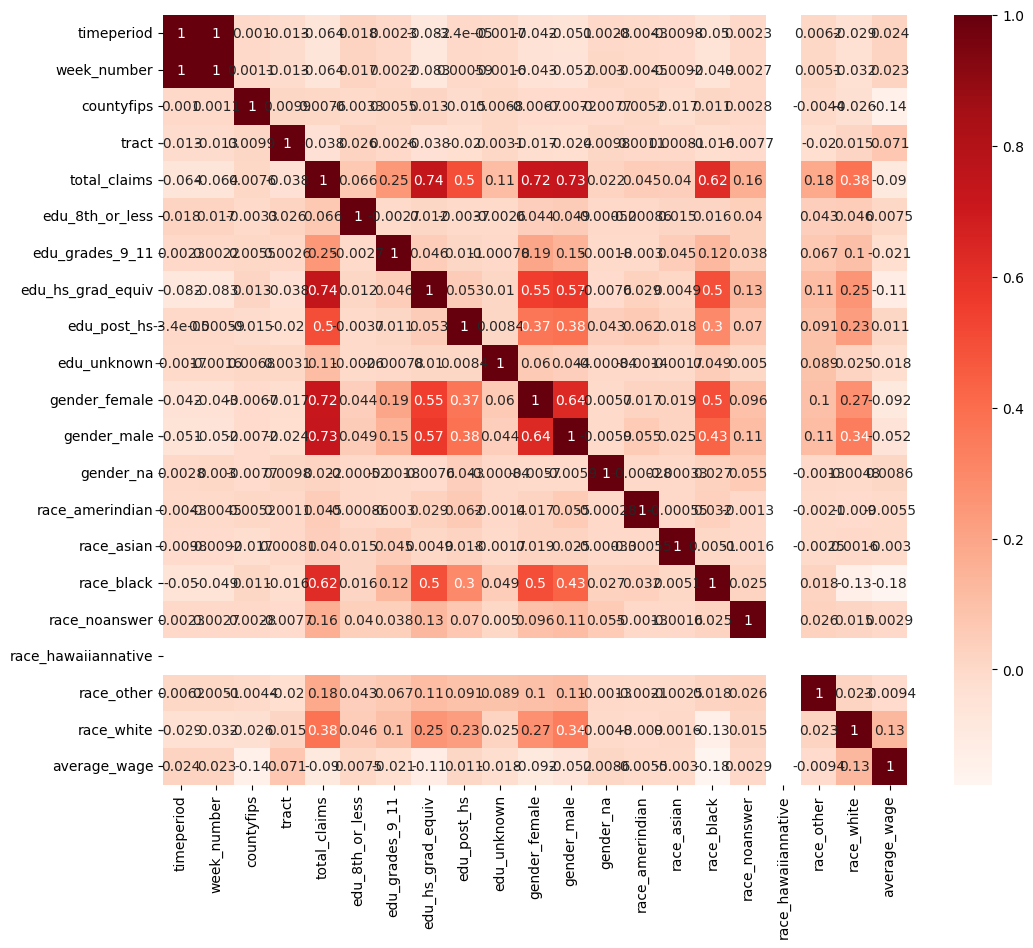

In [15]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [16]:
y = data.total_claims
x = data.drop(['total_claims', 'timeperiod'], axis = 1)

In [17]:
uuid, label = data['uu_id'].factorize(sort=True)

In [18]:
x['uu_id'] = uuid

In [19]:
x['tract_name'] = x['tract_name'].factorize()[0]

In [20]:
x['top_category_employer1'] = x['top_category_employer1'].factorize()[0]
x['top_category_employer2'] = x['top_category_employer2'].factorize()[0]
x['top_category_employer3'] = x['top_category_employer3'].factorize()[0]

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [22]:
model = HistGradientBoostingRegressor(loss="squared_error")
model.fit(x_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train

TypeError: fit() got an unexpected keyword argument 'verbose'

In [23]:
model = HistGradientBoostingRegressor(loss="squared_error")
model.fit(x_train, y_train)

HistGradientBoostingRegressor()

In [24]:
model.score(x_test, y_test)

0.9394960923993274

In [25]:
query = """
SELECT * FROM `ironhacks-data.ironhacks_competition.prediction_list` 
"""

In [26]:
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
pred = query_job.to_dataframe()
pred.head()

uu_id  week_number
0  5bf51fc2e162d6faf9e3cf79e4198378           44
1  420b44cc7e3f55d738df565421e59941           44
2  e39c66ecceec76ee8f9f811fa4a2d246           44
3  a90462cd11ae4e43144239bf7c4828a4           44
4  8b20a6749088c7ff1237983076ebfeaa           44

In [27]:
pred

uu_id  week_number
0    5bf51fc2e162d6faf9e3cf79e4198378           44
1    420b44cc7e3f55d738df565421e59941           44
2    e39c66ecceec76ee8f9f811fa4a2d246           44
3    a90462cd11ae4e43144239bf7c4828a4           44
4    8b20a6749088c7ff1237983076ebfeaa           44
..                                ...          ...
520  46c4f6c75e663b1ca82ea7994e6d83d3           44
521  1deebda501712e7595b531b8337bc31a           44
522  5a9758f65f001b6432ff31ff64a459d7           44
523  e8b3b95e93a6dc7dbb90f4e72e7ac065           44
524  932a58530abff8a48558e2a15639d453           44

[525 rows x 2 columns]

In [28]:
x['uu_id'] = label[x["uu_id"]]
x

uu_id  week_number  countyfips   tract  \
0      f013068de98db1470bd986137a0c6d23           16       18003     900   
1      21957d5517323845818d87623589e1ba           12       18089   10400   
2      6a5609f385912113b6f1014b958ed748           13       18089   11500   
3      46b2882ec4c373527ec33f7bd4f1388d           29       18089   20700   
4      37495d17e82f7df326bfc2c4c090f7b7           15       18089   21900   
...                                 ...          ...         ...     ...   
16827  6d4dc6590c52c9b265d5003bf90ddbbb           17       18063  210607   
16828  f35320206f3dd1ffc411e4ac127caf92           25       18163    3804   
16829  f35320206f3dd1ffc411e4ac127caf92           35       18163    3804   
16831  bbcb018f0e5e49e13636f6e78ce9f60f           13       18163   10203   
16832  bbcb018f0e5e49e13636f6e78ce9f60f           16       18163   10203   

       tract_name  edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  \
0               0                0                0                 14   
1               1                0                0                108   
2               2                0                0                  0   
3               3                0                0                  0   
4               4                0                0                 69   
...           ...              ...              ...                ...   
16827         491                0                0                  0   
16828         439                0                0                  0   
16829         439                0                0                 13   
16831         441                0                0                 48   
16832         441                0                0                 18   

       edu_post_hs  edu_unknown  ...  gender_male  gender_na  race_amerindian  \
0                0            0  ...            0          0                0   
1                0            0  ...           35          0                0   
2                0            0  ...            0          0                0   
3                0            0  ...            0          0                0   
4               83            0  ...           65          0                0   
...            ...          ...  ...          ...        ...              ...   
16827            0            0  ...            0          0                0   
16828           12            0  ...            0          0                0   
16829            0            0  ...            0          0                0   
16831            0            0  ...            0          0                0   
16832            0            0  ...           13          0                0   

       race_asian  race_black  race_noanswer  race_hawaiiannative  race_other  \
0               0          11              0                    0           0   
1               0           0              0                    0           0   
2               0          39              0                    0           0   
3               0          10              0                    0           0   
4               0         135              0                    0           0   
...           ...         ...            ...                  ...         ...   
16827           0           0              0                    0           0   
16828           0           0              0                    0           0   
16829           0           0              0                    0           0   
16831           0           0              0                    0           0   
16832           0           0              0                    0           0   

       race_white  average_wage  
0               0   8347.125000  
1               0   7036.636364  
2               0   7890.142857  
3               0   7534.375000  
4               0  11825.125000  
...           ...           ...  
16827           0  12758.200000  
16828         

In [29]:
for col in x.columns[2:]:
    li = []
    for i in pred['uu_id']:
        li.append(x.loc[x['uu_id'] == i, col].mean())
    pred[col] = li

In [30]:
pred

uu_id  week_number  countyfips     tract  \
0    5bf51fc2e162d6faf9e3cf79e4198378           44     18103.0  952800.0   
1    420b44cc7e3f55d738df565421e59941           44     18043.0   70400.0   
2    e39c66ecceec76ee8f9f811fa4a2d246           44     18099.0   20500.0   
3    a90462cd11ae4e43144239bf7c4828a4           44     18153.0   50300.0   
4    8b20a6749088c7ff1237983076ebfeaa           44     18071.0  967902.0   
..                                ...          ...         ...       ...   
520  46c4f6c75e663b1ca82ea7994e6d83d3           44     18141.0   11602.0   
521  1deebda501712e7595b531b8337bc31a           44     18141.0   11406.0   
522  5a9758f65f001b6432ff31ff64a459d7           44     18003.0   11603.0   
523  e8b3b95e93a6dc7dbb90f4e72e7ac065           44     18073.0  100901.0   
524  932a58530abff8a48558e2a15639d453           44     18091.0   41500.0   

     tract_name  edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  \
0         514.0              0.0         0.000000           1.375000   
1         142.0              0.0         1.750000           0.000000   
2         268.0              0.0         0.000000           0.909091   
3         276.0              0.0         0.384615           7.846154   
4         407.0              0.0         0.000000           2.545455   
..          ...              ...              ...                ...   
520        80.0              0.0         0.870968           8.838710   
521       426.0              0.0         0.000000           1.857143   
522       265.0              0.0         1.043478           0.000000   
523       325.0              0.0         0.000000           3.500000   
524       225.0              0.0         1.230769           6.538462   

     edu_post_hs  edu_unknown  ...  gender_male  gender_na  race_amerindian  \
0       0.000000     0.000000  ...     0.000000        0.0              0.0   
1       1.500000     0.000000  ...     0.000000        0.0              0.0   
2       1.090909     0.000000  ...     2.181818        0.0              0.0   
3       3.307692     0.000000  ...     6.461538        0.0              0.0   
4       0.000000     0.000000  ...     0.000000        0.0              0.0   
..           ...          ...  ...          ...        ...              ...   
520     1.000000     0.322581  ...     5.645161        0.0              0.0   
521     0.750000     0.000000  ...     0.357143        0.0              0.0   
522     3.173913     0.000000  ...     2.608696        0.0              0.0   
523     1.400000     0.000000  ...     1.800000        0.0              0.0   
524     3.423077     0.000000  ...     5.653846        0.0              0.0   

     race_asian  race_black  race_noanswer  race_hawaiiannative  race_other  \
0           0.0    0.000000            0.0                  0.0         0.0   
1           0.0    0.000000            0.0                  0.0         0.0   
2           0.0    0.000000            0.0                  0.0         0.0   
3           0.0    0.000000            0.0                  0.0         0.0   
4           0.0    0.000000            0.0                  0.0         0.0   
..          ...         ...            ...                  ...         ...   
520         0.0    0.000000            0.0                  0.0         0.0   
521         0.0    0.000000            0.0                  0.0         0.0   
522         0.0    1.043478            0.0                  0.0         0.0   
523         0.0    0.000000            0.0                  0.0         0.0   
524         0.0    0.000000            0.0                  0.0         0.0   

     race_white  average_wage  
0      3.500000   5008.500000  
1      3.375000   9019.666667  
2      2.545455   8928.000000  
3     17.576923  10040.857143  
4      5.727273   9013.818182  
..          ...           ...  
520    8.741935  14125.320000  
521    2.571429  11725.307692  
522    7.260870  41267.000000  
523    4.350000  10922.857143  
524 

In [31]:
pred['uu_id'] = pred['uu_id'].factorize(sort=True)[0]

In [32]:
x_test

uu_id  week_number  countyfips   tract  tract_name  edu_8th_or_less  \
4858      19            7       18097  341700         197                0   
13639    101            5       18127   50203          53                0   
16336    507            9       18019   50703         277                0   
8719     283           17       18141    2600         301                0   
16476    167            2       18097  310104         484                0   
...      ...          ...         ...     ...         ...              ...   
13549     96           18       18157    1700          51                0   
5520     191           27       18059  410900         275                0   
9317     265            1       18097  360202         367                0   
8475     104           33       18039     301         454                0   
9891     268           21       18141    3200         305                0   

       edu_grades_9_11  edu_hs_grad_equiv  edu_post_hs  edu_unknown  ...  \
4858                 0                 19            0            0  ...   
13639                0                  0            0            0  ...   
16336                0                  0            0            0  ...   
8719                 0                  0            0            0  ...   
16476                0                  0           11            0  ...   
...                ...                ...          ...          ...  ...   
13549                0                 22            0            0  ...   
5520                 0                  0            0            0  ...   
9317                 0                  0            0            0  ...   
8475                12                 35            0            0  ...   
9891                 0                  0            0            0  ...   

       gender_male  gender_na  race_amerindian  race_asian  race_black  \
4858            14          0                0           0           0   
13639           13          0                0           0           0   
16336            0          0                0           0           0   
8719             0          0                0           0           0   
16476            0          0                0           0           0   
...            ...        ...              ...         ...         ...   
13549           13          0                0           0          23   
5520             0          0                0           0           0   
9317             0          0                0           0           0   
8475            34          0                0           0           0   
9891             0          0                0           0          13   

       race_noanswer  race_hawaiiannative  race_other  race_white  \
4858               0                    0           0          12   
13639              0                    0           0          24   
16336              0                    0           0           0   
8719               0                    0           0           0   
16476              0                    0           0           0   
...              ...                  ...         ...         ...   
13549              0                    0           0           0   
5520               0                    0           0           0   
9317               0                    0           0           0   
8475               0                    0           0          38   
9891               0                    0           0           0   

       average_wage  
4858   10352.000000  
13639   8660.200000  
16336  12247.875000  
8719    9814.300000  
16476   5757.333333  
...             ...  
13549  10415.545455  
5520   12674.200000  
9317   15379.142857  
8475   17575.272727  
9891   10843.555556  

[2796 rows x 24 columns]

In [33]:
pred = pred.apply(pd.to_numeric)

In [34]:
predictions = gridcv_xgb.predict(pred)

NameError: name 'gridcv_xgb' is not defined

In [35]:
predictions

NameError: name 'predictions' is not defined

In [36]:
predictions = model.predict(pred)

In [37]:
out_df = pd.DataFrame()

In [38]:
out_df["uu_id"] = pred["uu_id"]
out_df["total_claims"] = predictions
out_df["week_numer"] = pred["week_number"]

In [39]:
out_df

uu_id  total_claims  week_numer
0      198     14.425678          44
1      126     13.200974          44
2      476     13.659573          44
3      353     19.863955          44
4      288     11.828839          44
..     ...           ...         ...
520    144     17.359895          44
521     52     13.806449          44
522    192     12.238001          44
523    486     12.946065          44
524    306     16.297354          44

[525 rows x 3 columns]

In [40]:
query = """
SELECT uu_id FROM `ironhacks-data.ironhacks_competition.prediction_list` 
"""

In [41]:
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
uu_id = query_job.to_dataframe()

In [42]:
uuid, label = uu_id['uu_id'].factorize(sort=True)

In [43]:
out_df["uu_id"] = label[out_df["uu_id"]]

In [44]:
out_df

uu_id  total_claims  week_numer
0    5bf51fc2e162d6faf9e3cf79e4198378     14.425678          44
1    420b44cc7e3f55d738df565421e59941     13.200974          44
2    e39c66ecceec76ee8f9f811fa4a2d246     13.659573          44
3    a90462cd11ae4e43144239bf7c4828a4     19.863955          44
4    8b20a6749088c7ff1237983076ebfeaa     11.828839          44
..                                ...           ...         ...
520  46c4f6c75e663b1ca82ea7994e6d83d3     17.359895          44
521  1deebda501712e7595b531b8337bc31a     13.806449          44
522  5a9758f65f001b6432ff31ff64a459d7     12.238001          44
523  e8b3b95e93a6dc7dbb90f4e72e7ac065     12.946065          44
524  932a58530abff8a48558e2a15639d453     16.297354          44

[525 rows x 3 columns]

In [45]:
out_df.to_csv("submission_prediction_output.csv", index=False)